# <center>Тема 6
## <center>Аугментація даних

Для роботи з глибинними згортковими нейронними мережами необхідно мати набори зображень, які містять сотні та тисячі зразків кожного класу. В реальносту буває досить складно знайти такий обсяг інформації. Тому для штучного збільшення обсягу навчальної вибірки використовують підхід, який називається аугментацією (доповненням) даних. Доповнення відбувається завдяки виконанню різних операцій над початковими зображеннями - їх масштабують, повертають на деякий кут, віддзеркалюють тощо. Таким чином, на основі одного зображення можна створити декілька його видозмінених копій. Аугментація не дозволить суттєво покращити ефективність мережі, але якість її навчання стане відчутно кращою у порівнянні із навчанням на початковій (не доповненій) вібирці.

Зазвичай аугментація застосовується у випадках, коли у початковому наборі даних не більше 200-300 зображень кожного класу. Але потрібно пам'ятати, що такий метод не завжди можна застосувати. Наприклад, якщо розпізнаються номери автомобілів, то віддзеркалення зображень з метою аугментації навпаки погіршить якість навчання. Оскільки цифри номеру, як і будь-яка інша текстова інформація, втрачають весь свій зміст та характерні ознаки у випадку віддзеркалення.

- В Keras аугментація здійснюється за допомогою генератора зображень ImageDataGenerator: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Розглянемо приклад роботи з генератором даних в завданні класифікації героїв коміксів Marvel.

Проведемо імпорт необхідних модулів та функцій, включно з генератором зображень ImageDataGenerator.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras import utils
from keras.preprocessing import image

import matplotlib.pyplot as plt

Using TensorFlow backend.


Оптимізуємо режим роботи відеокарти.

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
session = InteractiveSession(config=config)

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Задамо початкові параметри, такі як адреси папок із зображеннями та розміри зображень. Зверніть увагу, що на відміну від використання функції `image_dataset_from_directory()`, у випадку застосування генератора зображень потрібно попередньо розмістити навчальні зразки у трьох різних каталогах: дані для навчання, дані для валідації та дані для тестування. Також на цьому етапі задамо розмір батчу та створимо список із назвами класів.

In [3]:
# Каталог з даними для навчання
train_dir = 'D:/Drive/ІІС/Datasets/Conv_multi/marvel/train'
# Каталог з даними для валідації
val_dir = 'D:/Drive/ІІС/Datasets/Conv_multi/marvel/valid'
# Каталог з даними для тестування
test_dir = 'D:/Drive/ІІС/Datasets/Conv_multi/marvel/test'
# Розміри зображення
img_width, img_height = 256, 256
# Розмірність тензору на основі зображення для подання на вхід нейронної мережі
# backend Tensorflow, channels_last (три канали, тому що зображення кольорове)
input_shape = (img_width, img_height, 3)
# Розмір міні-вибірки
batch_size = 32

#Назви класів
classes = ['black widow', 'captain america', 'doctor strange', 'hulk', 'ironman', 'loki', 'spider-man', 'thanos']

Створюємо об'єкт-генератор зображень `ImageDataGenerator()` для навчальної вибірки. Даний об'єкт дозволить одразу під час зчитування зображень з каталогу здійснити над ними деякі перетворення. Наприклад, опція `rescale=1. / 255` виконає стандартизацію значень пікселів зображення. Інші параметри даного генератора використовуються для аугментації даних. Наприклад, задамо наступні налаштування:

- `rotation_range=15` - обертання зображення на максимум 15% від початкового положення;
- `width_shift_range=0.2` - зсув зображення по вертикалі на максимум 20% від початкового положення;
- `height_shift_range=0.2` - зсув зображення по горизонталі на максимум 20% від початкового положення;
- `zoom_range=0.2` - збільшення зображення на максимум 20%;
- `horizontal_flip=True` - віддзеркалення зображення за горизонталлю;
- `fill_mode='nearest` - режим заповнення пустих пікселів, що утворились внаслідок зсуву або обертання зображення. Значення *nearest* вказує на те, що пустіл ділянки будуть заповнені значеннями граничних пікселів початкового зображення.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                  rotation_range=15,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

Аналогічним чином створимо генератор, який буде використовуватись для валідаційної та тестової множини. Однак, під час валідації або тестування аугментація не застосовується. Тому єдиним параметром генератора буде `rescale=` для стандартизації вхідних значень.

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

Тепер створимо необхідні набори даних за допомогою методу `flow_from_directory()` генератора. В якості параметрів вказуємо адресу каталога з зображеннями, розмір зображення для його автоматичного масштабування (має відповідати формі входу нейронної мережі), розмір батчу та режим міток класів (в нашому випадку *categorical*, оскільки в завданні більше 2 класів).

In [4]:
# Генератор для зображень із папки для навчання
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Генератори для тестової та валідаційної вибірки
val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 1660 images belonging to 8 classes.
Found 305 images belonging to 8 classes.
Found 197 images belonging to 8 classes.


Тепер перевіримо роботу генератора навчальних зображень. Завантажимо довільне зображення із навчального каталогу.

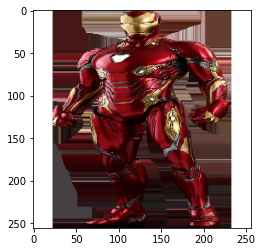

In [5]:
image_file_name = train_dir + '/ironman/pic_001.jpg'
img = image.load_img(image_file_name, target_size=(256, 256))
plt.imshow(img)

Тестуємо генератор. Виведемо перші 4 зображення із згенерованого батчу.

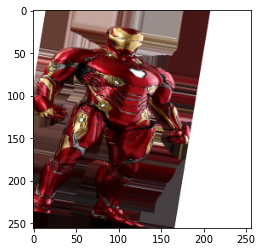

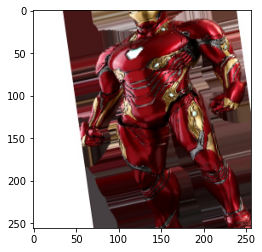

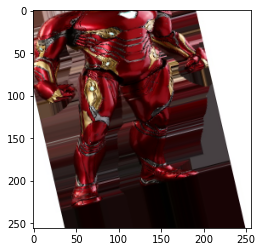

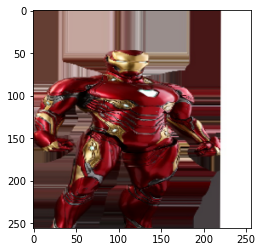

In [6]:
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

Після того, як навчальні дані підготовлені, можна створити модель нейронної мережі.

In [7]:
# Створюємо послідовну модель
model = Sequential()

# Згортковий прошарок
model.add(Conv2D(32, (5, 5), padding='same', input_shape=input_shape, activation='relu'))
# Прошарок підвибірки
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Згортковий прошарок
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# Згортковий прошарок
# Прошарок підвибірки
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Згортковий прошарок
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# Згортковий прошарок
# Прошарок підвибірки
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Згортковий прошарок
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# Прошарок підвибірки
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Повнозв'язна частина нейронної мережі для класифікації
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.5))

# Вихідний прошарок, 8 нейронів (за кількістю класів)
model.add(Dense(8, activation="softmax"))

# Компілюємо модель. В якості оптимізатора вказуємо Adam з модифікованим значенням швидкості навчання
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-5), metrics=["accuracy"])

Навчаємо описану нейронну мережу. У методі `fit()` вказуємо наступні атрибути:

- `train_generator` - посилання на об'єкт-генератор навчальних даних;
- `steps_per_epoch = 40` - кількість батчів за одну епоху. Повинна приблизно дорівнювати (кількість картинок в навчальному каталозі / розмір батчу);
- `epochs=150` - кількість епох, визначається емпірично;
- `validation_data=val_generator` - посилання на об'єкт-генератор даних для валідації;
- `validation_steps= 10` - кількість батчів за одну епоху. Повинна приблизно дорівнювати (кількість картинок в каталозі для валідації / розмір батчу).

In [8]:
history = model.fit(
            train_generator,
            steps_per_epoch = 40,
            epochs=150,
            validation_data=val_generator,
            validation_steps= 10)

Epoch 1/150
40/40 [==============================] - 53s 1s/step - loss: 12.0474 - accuracy: 0.1450 - val_loss: 11.8009 - val_accuracy: 0.1672
Epoch 2/150
40/40 [==============================] - 34s 857ms/step - loss: 11.6173 - accuracy: 0.1442 - val_loss: 11.3672 - val_accuracy: 0.1705
Epoch 3/150
40/40 [==============================] - 30s 750ms/step - loss: 11.1889 - accuracy: 0.1293 - val_loss: 10.9583 - val_accuracy: 0.1344
Epoch 4/150
40/40 [==============================] - 31s 765ms/step - loss: 10.7683 - accuracy: 0.1685 - val_loss: 10.5597 - val_accuracy: 0.2066
Epoch 5/150
40/40 [==============================] - 31s 768ms/step - loss: 10.3797 - accuracy: 0.1661 - val_loss: 10.1741 - val_accuracy: 0.2328
Epoch 6/150
40/40 [==============================] - 31s 775ms/step - loss: 10.0025 - accuracy: 0.1583 - val_loss: 9.8069 - val_accuracy: 0.2689
Epoch 7/150
40/40 [==============================] - 31s 774ms/step - loss: 9.6264 - accuracy: 0.1873 - val_loss: 9.4539 - val_a

Побудуємо графік навчання.

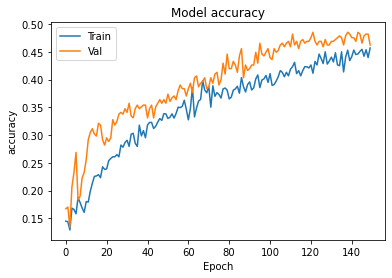

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Перенавчання немає. Проведемо оцінку якості роботи мережі на тестовій множині, вказавши у методі `evaluate()` посилання на генератор даних для тестування.

In [10]:
scores = model.evaluate(test_generator)
print(f"Доля правильних відповідей на тестових даних: {(scores[1]*100):.2f}")

7/7 [==============================] - 3s 430ms/step - loss: 1.9899 - accuracy: 0.3909
Доля правильних відповідей на тестових даних: 39.09


Як бачимо, мережа демонструє не найкращі показники на тестовій множині. Для покращення результатів необхідно використовувати більш складну архітектуру мережі.

Застосуємо навчену мережу для розпізнавання довільного зображення.

In [11]:
from IPython.display import Image
from tkinter.filedialog import askopenfilename

(-0.5, 255.5, 255.5, -0.5)

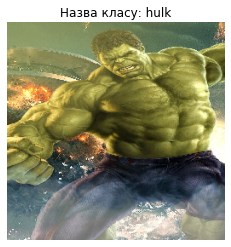

In [36]:
# Викликаємо віконце для вибору файлу
img_path = askopenfilename()

# Імпортуємо зображення та масштабуємо його (img_path, ширина=256, висота=256)
img = image.load_img(img_path, target_size=(256, 256))

# Перетворюємо зображення в масив
x = image.img_to_array(img)
x = x.reshape(-1, 256, 256, 3)

# Подаємо зображення на вхід мережі для класифікації
prediction = model.predict(x)

# Визначаємо код класу
prediction = np.argmax(prediction)

# Показуємо результат
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f"Назва класу: {classes[prediction]}" )
plt.axis("off")